## Voting in Chainladder
### Getting Started
This tutorial focuses on using `VotingChainladder`, which allows the user to select which actuarial model(s) to rely on for the projection of ultimates. 

Note that a lot of the examples shown here might not be applicable in a real world scenario, and is only meant to demonstrate some of the functionalities included in the package. The user should always exercise their best actuarial judgement, and follow any applicable laws, the Code of Professional Conduct, and applicable Actuarial Standards of Practice.

Be sure to make sure your packages are updated. For more info on how to update your pakages, visit [Keeping Packages Updated](https://chainladder-python.readthedocs.io/en/latest/install.html#keeping-packages-updated).

In [1]:
# Black linter, optional
%load_ext lab_black

import pandas as pd
import numpy as np
import chainladder as cl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

print("pandas: " + pd.__version__)
print("numpy: " + np.__version__)
print("chainladder: " + cl.__version__)

pandas: 1.3.4
numpy: 1.21.2
chainladder: 0.8.10


Let's load in the `raa` dataset.

In [3]:
raa = cl.load_sample("raa")
raa

,12,24,36,48,60,72,84,96,108,120
1981,"5,012","8,269","10,907","11,805","13,539","16,181","18,009","18,608","18,662","18,834"
1982,106,"4,285","5,396","10,666","13,782","15,599","15,496","16,169","16,704",
1983,"3,410","8,992","13,873","16,141","18,735","22,214","22,863","23,466",,
1984,"5,655","11,555","15,766","21,266","23,425","26,083","27,067",,,
1985,"1,092","9,565","15,836","22,169","25,955","26,180",,,,
1986,"1,513","6,445","11,702","12,935","15,852",,,,,
1987,557,"4,020","10,946","12,314",,,,,,
1988,"1,351","6,947","13,112",,,,,,,
1989,"3,133","5,395",,,,,,,,
1990,"2,063",,,,,,,,,


First, let's start with the `Chainladder()` model. Recall that this model requires no parameters and arguments.

In [12]:
# Chainladder Ultimate
cl_ult = cl.Chainladder().fit(raa).ultimate_
cl_ult

,2261
1981,"18,834"
1982,"16,858"
1983,"24,083"
1984,"28,703"
1985,"28,927"
1986,"19,501"
1987,"17,749"
1988,"24,019"
1989,"16,045"
1990,"18,402"


In [29]:
apriori = cl_ult * 0 + float(cl_ult.mean())
apriori

,2261
1981,"21,312"
1982,"21,312"
1983,"21,312"
1984,"21,312"
1985,"21,312"
1986,"21,312"
1987,"21,312"
1988,"21,312"
1989,"21,312"
1990,"21,312"


In [34]:
bf_ult = cl.BornhuetterFerguson(apriori=1).fit(raa, sample_weight=apriori).ultimate_
bf_ult

,2261
1981,"18,834"
1982,"16,899"
1983,"24,012"
1984,"28,282"
1985,"28,204"
1986,"19,840"
1987,"18,840"
1988,"22,790"
1989,"19,541"
1990,"20,986"


In [33]:
bf_ult = cl.BornhuetterFerguson(apriori=0.75).fit(raa, sample_weight=apriori).ultimate_
bf_ult

,2261
1981,"18,834"
1982,"16,850"
1983,"23,876"
1984,"27,978"
1985,"27,698"
1986,"18,843"
1987,"17,209"
1988,"20,370"
1989,"16,005"
1990,"16,255"


In [13]:
# Mean Chainladder Ultimate


,2261
1981,"21,312"
1982,"21,312"
1983,"21,312"
1984,"21,312"
1985,"21,312"
1986,"21,312"
1987,"21,312"
1988,"21,312"
1989,"21,312"
1990,"21,312"


In [24]:
# Load estimators to vote between
bcl = cl.Chainladder()
bcl_ibnr = bcl.fit(raa).ibnr_.to_frame()
cc = cl.CapeCod()
cc_ibnr = cc.fit(raa, sample_weight=apriori).ibnr_.to_frame()
estimators = [("bcl", bcl), ("cc", cc)]
estimators

[('bcl', Chainladder()), ('cc', CapeCod())]

In [26]:
# Fit VotingChainladder using CC after 1987 and a blend of BCL and CC otherwise
vot = cl.VotingChainladder(
    estimators=estimators,
    weights=lambda origin: (0, 1) if origin.year > 1987 else (0.5, 0.5),
)
vot.fit(raa, sample_weight=apriori)
vot_ibnr = vot.ibnr_.to_frame()

In [27]:
# Plotting
plot_ibnr = pd.concat([bcl_ibnr, vot_ibnr, cc_ibnr], axis=1)
plot_ibnr.columns = ["BCL", "Voting", "CC"]

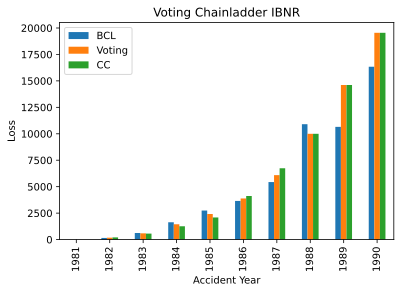

In [6]:
ax = plot_ibnr.plot(
    kind="bar",
    ylim=(0, None),
    title="Voting Chainladder IBNR",
    xlabel="Accident Year",
    ylabel="Loss",
)